In [1]:
import os
os.environ['XRT_TPU_CONFIG']
#='tpu_worker;0;10.77.227.146:8470'

'tpu_worker;0;10.77.227.146:8470'

In [11]:
%matplotlib inline
RESULT_IMG_PATH = '/tmp/test_result.png'
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from IPython import display 

    
def plot_results(images):
    #display.clear_output()
    num_images = images.shape[0]
    fig, axes = plt.subplots(4, 6, figsize=(11, 9))

    for i, ax in enumerate(fig.axes):
        ax.axis('off')
        if i >= num_images:
          continue
        img = images[i]
        img = img.squeeze() # [1,Y,X] -> [Y,X]
        ax.imshow(img)
    plt.savefig(RESULT_IMG_PATH, transparent=True)
    #display(RESULT_IMG_PATH)

In [12]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.optim import Adam
import torch.nn.functional as F

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu



In [48]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.001
FLAGS['momentum'] = 0.5
FLAGS['num_epochs'] = 15
FLAGS['num_cores'] = 8
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [49]:
def mnist_data():
    compose = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    out_dir = '{}/dataset'.format(FLAGS['datadir'])
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [50]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(4*4*64, 1)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2), 0.01)
        x = self.bn1(x)
        x = F.leaky_relu(F.max_pool2d(self.conv2(x), 2), 0.01)
        x = self.bn2(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x), 0.01)
        return F.sigmoid(x)            
        

In [51]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        self.linear1 = nn.Linear(100, 1024) # relue activation
        self.bn1 = nn.BatchNorm1d(1024)
        self.linear2 = nn.Linear(1024, 7*7*128) # relu activation
        self.bn2 = nn.BatchNorm1d(7*7*128) # reshape to (-1, 7, 7, 128)
        self.conv1 = nn.ConvTranspose2d(
            in_channels=128, 
            out_channels=64, 
            kernel_size=4,
            stride=2, 
            padding=1, 
            bias=False
        ) #relu activation
        self.bn3 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(
            in_channels=64, 
            out_channels=1, 
            kernel_size=4,
            stride=2, 
            padding=1, 
            bias=False
        ) # tanh activation
        
        
            
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = x.view(x.shape[0], 128, 7, 7)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.conv2(x)
        x = F.tanh(x)
        return x

    


In [52]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [53]:
def real_data_target(size, device):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def fake_data_target(size, device):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [54]:
# Noise
def noise(size, device):
    n = Variable(torch.randn(size, 100))
    return n.to(device)

In [55]:
def train_gan(rank):
    torch.manual_seed(1)
    
    if not xm.is_master_ordinal():
        # Barrier: Wait until master is done downloading
        xm.rendezvous('download_only_once')
    # Dataset
    data = mnist_data()
    if xm.is_master_ordinal():
        # Master is done, other workers can proceed now
        xm.rendezvous('download_only_once')
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        data,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True)
    

    # Create loader with data, so that we can iterate over it
    #train_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
    train_loader = torch.utils.data.DataLoader(
      data,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

    # Num batches
    num_batches = len(train_loader)
    
    device = xm.xla_device()
    
    generator = GenerativeNet().to(device)
    generator.apply(init_weights)

    discriminator = DiscriminativeNet().to(device)
    discriminator.apply(init_weights)
    
    # Optimizers
    d_optimizer = Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
    g_optimizer = Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))

    # Number of epochs
    num_epochs = FLAGS['num_epochs'] 
    # Loss function
    loss = nn.BCELoss()
    
    num_test_samples = 24
    test_noise = noise(num_test_samples, device)
    
    def train_step_discriminator(optimizer, real_data, fake_data, device):
        # Reset gradients
        optimizer.zero_grad()

        # 1. Train on Real Data
        prediction_real = discriminator(real_data)
        # Calculate error and backpropagate
        error_real = loss(prediction_real, real_data_target(real_data.size(0), device))
        

        # 2. Train on Fake Data
        prediction_fake = discriminator(fake_data)
        # Calculate error and backpropagate

        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0), device))
        total_error = error_real + error_fake
        total_error.backward()

        # Update weights with gradients
        xm.optimizer_step(optimizer)

        return total_error, prediction_real, prediction_fake
        #return (0, 0, 0)

    def train_step_generator(optimizer, fake_data, device):
        # Reset gradients
        optimizer.zero_grad()
        # Sample noise and generate fake data
        prediction = discriminator(fake_data)
        # Calculate error and backpropagate
        error = loss(prediction, real_data_target(prediction.size(0), device))
        error.backward()
        # Update weights with gradients
        xm.optimizer_step(optimizer)

        # Return error
        return error


    def train_loop_fn(loader):
        tracker = xm.RateTracker()
        for n_batch, (real_batch,_) in enumerate(loader):
            # Train Step Descriminator
            real_data = Variable(real_batch).to(device)
            fake_data = generator(noise(real_data.size(0), device)).detach()
            d_error, d_pred_real, d_pred_fake = train_step_discriminator(d_optimizer,
                                                                real_data, fake_data, device)
            #Train Step Generator
            fake_data = generator(noise(real_batch.size(0), device))
            g_error = train_step_generator(g_optimizer, fake_data, device)
            #print(f'D_ERROR: {d_error.item()}, G_ERROR: {g_error.item()}')
        return d_error.item(), g_error.item()


            # Display Test Images
            # Save Model Checkpoints

    for epoch in range(1, FLAGS['num_epochs'] +1):
        para_loader = pl.ParallelLoader(train_loader, [device])
        d_error, g_error = train_loop_fn (para_loader.per_device_loader(device))
        xm.master_print("Finished training epoch {}: D_error:{}, G_error: {}".format(epoch, d_error, g_error))
        if rank == 0 and epoch %5 == 0:
            # Retrieve tensors that are on TPU core 0 and plot.
            plot_results(generator(test_noise).detach().cpu())
    #return generator

# Start training processes
def _mp_fn(rank, flags):
    global FLAGS
    FLAGS = flags
    torch.set_default_tensor_type('torch.FloatTensor')
    train_gan(rank)
    #if rank == 0:
      # Retrieve tensors that are on TPU core 0 and plot.
      # plot_results(images.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')



/home/sivaibhav/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/sivaibhav/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/sivaibhav/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/sivaibhav/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Finished training epoch 1: D_error:1.3421424627304077, G_error: 0.6593481302261353
Finished training epoch 2: D_error:1.341268539428711, G_error: 0.6604403257369995
Finished training epoch 3: D_error:1.2676715850830078, G_error: 0.674224317073822
Finished training epoch 4: D_error:1.2349848747253418, G_error: 0.6651897430419922
Finished training epoch 5: D_error:1.195441484451294, G_error: 0.6613254547119141
Finished training epoch 6: D_error:1.18717622756958, G_error: 0.6681320071220398
Finished training epoch 7: D_error:1.1234701871871948, G_error: 0.6295963525772095
Finished training epoch 8: D_error:1.1086325645446777, G_error: 0.6372564435005188
Finished training epoch 9: D_error:1.2320305109024048, G_error: 0.6844649314880371
Finished training epoch 10: D_error:1.044712781906128, G_error: 0.6714675426483154
Finished training epoch 11: D_error:0.9928157329559326, G_error: 0.6504250168800354
Finished training epoch 12: D_error:1.051196575164795, G_error: 0.6562619805335999
Finished

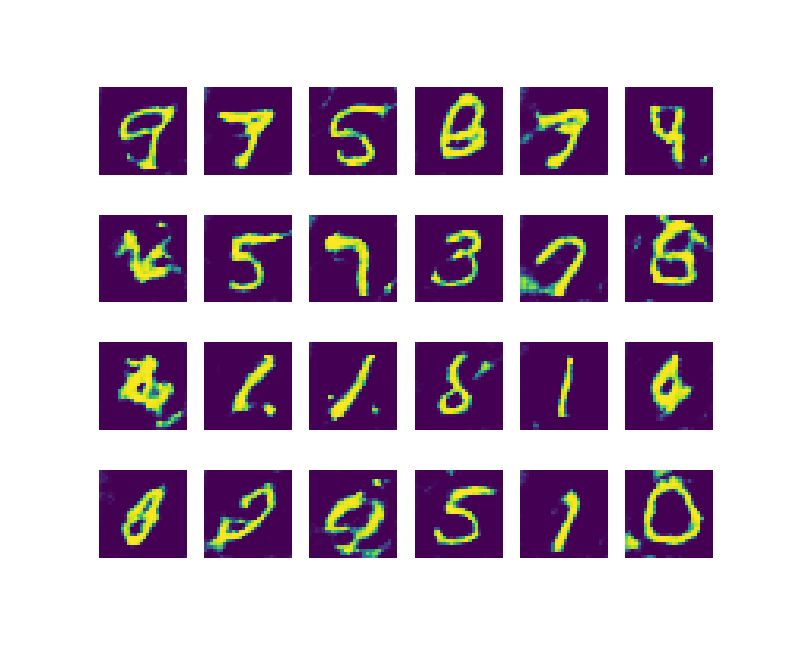

In [56]:
from IPython.display import Image
Image(filename=RESULT_IMG_PATH)

In [28]:
from io import BytesIO
import PIL
from IPython.display import display, Image



In [36]:
def sample_mp (rank, flags):
    num_test_samples = 24
    generator = GenerativeNet()
    test_noise = noise(num_test_samples, 'cpu')
    plot_results(generator(test_noise).detach().cpu())

'/tmp/test_result.png'

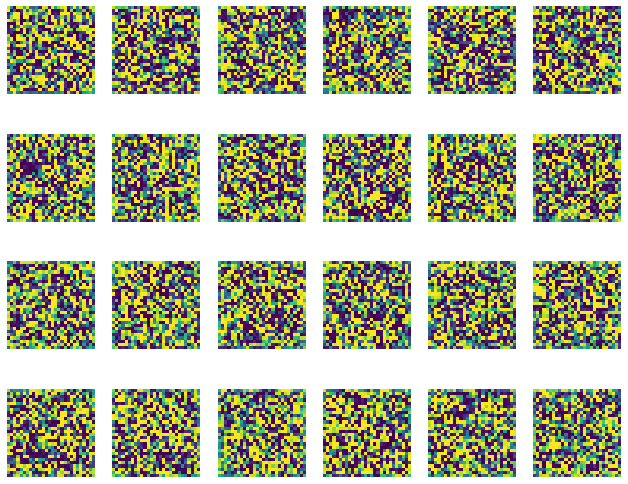

In [37]:
sample_mp(0, "")

'/tmp/test_result.png'

SystemExit: 0

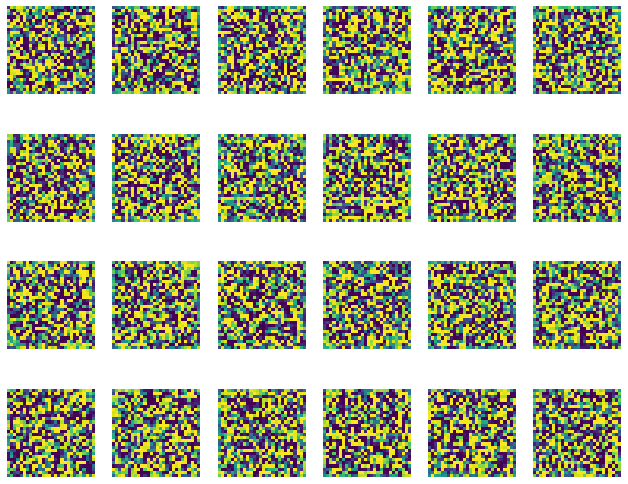

In [38]:
xmp.spawn(sample_mp, args=(FLAGS,), nprocs=1,
          start_method='fork')